<a href="https://colab.research.google.com/github/melab-cmu/Uncertainty-Analysis-Lab/blob/main/TORRE_MEASURE-ERROR_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WK 3 Uncertainty Analysis Lab**



*   Run-level summary - one row per run
*   Set-level summary - one row per experiment set: material x thickness
*  Cross-set comparison - normalized + ranked metrics per set



 CONFIG

In [ ]:
from __future__ import annotations

In [ ]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd

In [ ]:
DATA_DIR = Path(r"/content/drive/MyDrive/SPRING GENERAL/WK 3 Measurement/12831 - Test Bed Data for Assignment 3")
EXPORT_CSV = True

In [ ]:
# Standard deviation multiplier for outlier flagging
# From LBD 3.1 -- applying 3-sigma rule
STD_MULT = 3.0

HELPERS
Translated and applied from formulas provided in *Learn By Doing 3.1 and 3.2*

In [ ]:
def read_csv_safe(fp: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(fp)
    except UnicodeDecodeError:
        return pd.read_csv(fp, encoding="latin1")

def find_column(df: pd.DataFrame, keywords, prefer=None):
    cols = list(df.columns)
    low = [c.lower() for c in cols]

    candidates = [cols[i] for i, c in enumerate(low) if any(k in c for k in keywords)]
    if not candidates:
        return None

    if prefer:
        preferred = [c for c in candidates if any(p in c.lower() for p in prefer)]
        if preferred:
            return preferred[0]

    return candidates[0]

def summarize(series: pd.Series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return np.nan, np.nan, np.nan, np.nan
    return float(s.mean()), float(s.std(ddof=1)), float(s.min()), float(s.max())

def count_outliers(series: pd.Series, mean: float, std: float):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0 or std == 0 or np.isnan(std):
        return 0
    return int(np.sum(np.abs(s - mean) > STD_MULT * std))

def parse_meta_from_filename(fname: str):
    f = fname.lower()

    material = "aluminum" if "aluminum" in f else "steel" if "steel" in f else "unknown"

    if "1_2" in f:
        thickness = "1/2 in"
    elif "3_8" in f:
        thickness = "3/8 in"
    else:
        thickness = "unknown"

    m = re.search(r"run\s*0*([1-9]\d*)", f)
    run = f"run{m.group(1)}" if m else "unknown"

    return material, thickness, run

def minmax(series: pd.Series) -> pd.Series:
    s = pd.to_numeric(series, errors="coerce")
    mn, mx = np.nanmin(s), np.nanmax(s)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
        return pd.Series(np.nan, index=series.index)
    return (s - mn) / (mx - mn)

NOTE


> The DAQ files do not contain explicit acceleration column names (e.g., 'accel_z').
Instead, acceleration channels are labeled generically as g4 and g5.
Based on the sensor wiring configuration and consistent availability across all runs,
**g4** is selected as the representative vertical acceleration channel for run-level analysis.
**This assumption is documented and can be swapped to g5 if later validation indicates a different axis alignment.**



DISCOVER AND PAIR FILES (AURDINO + DAQ)

In [ ]:
arduino_files = list(DATA_DIR.rglob("*arduino_motion_raw*.csv"))
daq_files = list(DATA_DIR.rglob("*daq_sensors_1000hz*.csv"))

if not arduino_files:
    raise RuntimeError(f"No Arduino CSVs found under: {DATA_DIR}")
if not daq_files:
    raise RuntimeError(f"No DAQ CSVs found under: {DATA_DIR}")

daq_lookup = {}
for fp in daq_files:
    material, thickness, run = parse_meta_from_filename(fp.name)
    daq_lookup[(material, thickness, run)] = fp

pairs = []
for a_fp in arduino_files:
    material, thickness, run = parse_meta_from_filename(a_fp.name)
    d_fp = daq_lookup.get((material, thickness, run))
    if d_fp is not None:
        pairs.append({
            "material": material,
            "thickness": thickness,
            "run": run,
            "arduino_path": a_fp,
            "daq_path": d_fp
        })

if not pairs:
    raise RuntimeError(
        "No Arduino/DAQ pairs matched.\n"
        "This usually means filename conventions differ (RUN tokens, thickness tokens, etc.)."
    )

**PART 1 RUN-LEVEL SUMMARY**

In [ ]:
rows = []

for p in pairs:
    df_a = read_csv_safe(p["arduino_path"])
    df_d = read_csv_safe(p["daq_path"])

    # Hard-code columns based on provided csv headers
    vel_col = "vel_fps"
    accel_col = "g4"  # if wrong, switch to "g5"

    # Guardrails (fail loud if a file doesn't have expected columns)
    if vel_col not in df_a.columns:
        raise RuntimeError(f"Missing '{vel_col}' in Arduino file: {p['arduino_path'].name}. Columns: {list(df_a.columns)}")
    if accel_col not in df_d.columns:
        raise RuntimeError(f"Missing '{accel_col}' in DAQ file: {p['daq_path'].name}. Columns: {list(df_d.columns)}")

    vel = pd.to_numeric(df_a[vel_col], errors="coerce")
    accel = pd.to_numeric(df_d[accel_col], errors="coerce")

    a_mean, a_std, a_min, a_max = summarize(accel)
    v_mean, v_std, v_min, v_max = summarize(vel)

    rows.append({
        "material": p["material"],
        "thickness": p["thickness"],
        "run": p["run"],

        "accel_col": accel_col,
        "vel_col": vel_col,

        "accel_mean": a_mean,
        "accel_std": a_std,
        "accel_min": a_min,
        "accel_max": a_max,
        "accel_outliers": count_outliers(accel, a_mean, a_std),

        "vel_mean": v_mean,
        "vel_std": v_std,
        "vel_min": v_min,
        "vel_max": v_max,
    })

run_df = pd.DataFrame(rows)

if run_df.empty:
    raise RuntimeError(
        "run_df is empty even after hard-coding columns.\n"
        "This would indicate pairs are empty or numeric conversion produced all-NaNs."
    )

run_df["run_num"] = run_df["run"].str.extract(r"(\d+)").astype(int)
run_df = run_df.sort_values(["material", "thickness", "run_num"]).drop(columns=["run_num"]).reset_index(drop=True)

display(run_df)

if EXPORT_CSV:
    run_df.to_csv(DATA_DIR / "run_level_summary.csv", index=False)


,material,thickness,run,accel_col,vel_col,accel_mean,accel_std,accel_min,accel_max,accel_outliers,vel_mean,vel_std,vel_min,vel_max
0,aluminum,1/2 in,run1,g4,vel_fps,0.021295,0.026312,-0.013016,0.157852,503,-0.000830,1.251564,-1.0,3.0
1,aluminum,1/2 in,run2,g4,vel_fps,0.021403,0.027628,-0.019096,0.155292,709,0.030135,1.261484,-1.0,3.0
2,aluminum,1/2 in,run3,g4,vel_fps,0.019329,0.025712,-0.024535,0.169211,707,0.019251,1.260946,-1.0,3.0
3,aluminum,3/8 in,run1,g4,vel_fps,0.023602,0.032044,-0.009816,0.179610,681,0.022822,1.261878,-1.0,3.0
4,aluminum,3/8 in,run2,g4,vel_fps,0.023564,0.028547,-0.014296,0.182810,642,0.023348,1.263358,-1.0,3.0
5,aluminum,3/8 in,run3,g4,vel_fps,0.023270,0.028968,-0.009816,0.171451,538,0.013987,1.256316,-1.0,3.0
6,steel,3/8 in,run1,g4,vel_fps,0.031085,0.031298,-0.009016,0.160091,274,0.018607,1.263682,-1.0,3.0
7,steel,3/8 in,run2,g4,vel_fps,0.027519,0.030161,-0.012056,0.171451,468,0.010781,1.258874,-1.0,3.0
8,steel,3/8 in,run3,g4,vel_fps,0.026999,0.030557,-0.014776,0.184730,406,0.008536,1.252733,-1.0,3.0


**PART 1 SET-LEVEL SUMMARY**

In [ ]:
set_df = (
    run_df
    .groupby(["material", "thickness"], as_index=False)
    .agg(
        n_runs=("run", "count"),

        accel_mean=("accel_mean", "mean"),
        accel_std_between_runs=("accel_mean", "std"),
        accel_max=("accel_max", "max"),
        accel_min=("accel_min", "min"),
        total_accel_outliers=("accel_outliers", "sum"),

        vel_mean=("vel_mean", "mean"),
        vel_std_between_runs=("vel_mean", "std"),
        vel_max=("vel_max", "max"),
        vel_min=("vel_min", "min"),
    )
)

display(set_df)

if EXPORT_CSV:
    set_df.to_csv(DATA_DIR / "set_level_summary.csv", index=False)

,material,thickness,n_runs,accel_mean,accel_std_between_runs,accel_max,accel_min,total_accel_outliers,vel_mean,vel_std_between_runs,vel_max,vel_min
0,aluminum,1/2 in,3,0.020676,0.001168,0.169211,-0.024535,1919,0.016185,0.015708,3.0,-1.0
1,aluminum,3/8 in,3,0.023478,0.000182,0.182810,-0.014296,1861,0.020053,0.005260,3.0,-1.0
2,steel,3/8 in,3,0.028534,0.002224,0.184730,-0.014776,1148,0.012641,0.005287,3.0,-1.0


**CROSS-SET COMPARISON** Normalized + ranked metrics per set


In [ ]:
cross_df = set_df.copy()

cross_df["norm_accel_mean"] = minmax(cross_df["accel_mean"])
cross_df["norm_vel_mean"] = minmax(cross_df["vel_mean"])
cross_df["norm_outliers"] = minmax(cross_df["total_accel_outliers"])

cross_df["score"] = (
    0.45 * cross_df["norm_accel_mean"] +
    0.45 * cross_df["norm_vel_mean"] -
    0.10 * cross_df["norm_outliers"]
)

cross_df["rank"] = cross_df["score"].rank(ascending=False, method="min").astype(int)

cross_df = cross_df.sort_values(["rank", "material", "thickness"]).reset_index(drop=True)
display(cross_df)

if EXPORT_CSV:
    cross_df.to_csv(DATA_DIR / "cross_set_comparison.csv", index=False)

print(f"✓ Completed. CSVs written to: {DATA_DIR}" if EXPORT_CSV else "✓ Completed (no CSV export).")

,material,thickness,n_runs,accel_mean,accel_std_between_runs,accel_max,accel_min,total_accel_outliers,vel_mean,vel_std_between_runs,vel_max,vel_min,norm_accel_mean,norm_vel_mean,norm_outliers,score,rank
0,aluminum,3/8 in,3,0.023478,0.000182,0.182810,-0.014296,1861,0.020053,0.005260,3.0,-1.0,0.356673,1.000000,0.924773,0.518026,1
1,steel,3/8 in,3,0.028534,0.002224,0.184730,-0.014776,1148,0.012641,0.005287,3.0,-1.0,1.000000,0.000000,0.000000,0.450000,2
2,aluminum,1/2 in,3,0.020676,0.001168,0.169211,-0.024535,1919,0.016185,0.015708,3.0,-1.0,0.000000,0.478189,1.000000,0.115185,3


✓ Completed. CSVs written to: /content/drive/MyDrive/SPRING GENERAL/WK 3 Measurement/12831 - Test Bed Data for Assignment 3


## PART 2 CHARACTERIZATION OF ERRORS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

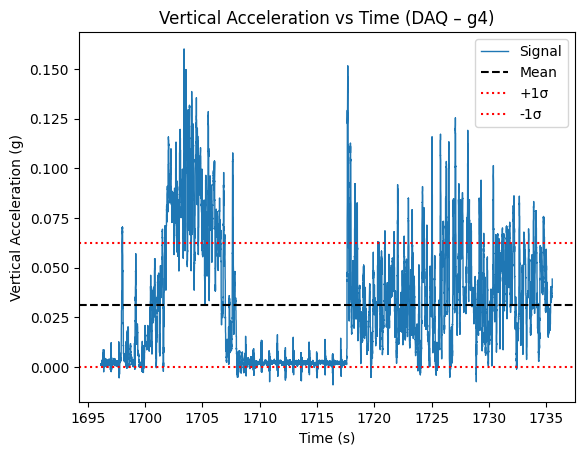

Acceleration mean: 0.03108 g
Acceleration std (aleatory): 0.03130 g


In [ ]:
# Load one representative run (example: first paired run)
df_d = read_csv_safe(pairs[0]["daq_path"])

time_accel = df_d["time_ms"] / 1000.0  # seconds
accel = pd.to_numeric(df_d["g4"], errors="coerce")

accel_mean = accel.mean()
accel_std = accel.std(ddof=1)

plt.figure()
plt.plot(time_accel, accel, linewidth=1, label="Signal")

plt.axhline(accel_mean, linestyle="--", color="black", label="Mean")
plt.axhline(accel_mean + accel_std, linestyle=":", color="red", label="+1σ")
plt.axhline(accel_mean - accel_std, linestyle=":", color="red", label="-1σ")

plt.xlabel("Time (s)")
plt.ylabel("Vertical Acceleration (g)")
plt.title("Vertical Acceleration vs Time (DAQ – g4)")
plt.legend()
plt.show()

print(f"Acceleration mean: {accel_mean:.5f} g")
print(f"Acceleration std (aleatory): {accel_std:.5f} g")

In [ ]:
cross_df = set_df.copy()

cross_df["norm_accel_mean"] = minmax(cross_df["accel_mean"])
cross_df["norm_vel_mean"] = minmax(cross_df["vel_mean"])
cross_df["norm_outliers"] = minmax(cross_df["total_accel_outliers"])

cross_df["score"] = (
    0.45 * cross_df["norm_accel_mean"] +
    0.45 * cross_df["norm_vel_mean"] -
    0.10 * cross_df["norm_outliers"]
)

cross_df["rank"] = cross_df["score"].rank(ascending=False, method="min").astype(int)
cross_df = cross_df.sort_values(["rank", "material", "thickness"])

display(cross_df)

if EXPORT_CSV:
    cross_df.to_csv(DATA_DIR / "P3-cross_set_comparison.csv", index=False)

print(f"✓ Completed. CSVs written to: {DATA_DIR}" if EXPORT_CSV else "✓ Completed (no CSV export).")

,material,thickness,n_runs,accel_mean,accel_std_between_runs,accel_max,accel_min,total_accel_outliers,vel_mean,vel_std_between_runs,vel_max,vel_min,norm_accel_mean,norm_vel_mean,norm_outliers,score,rank
1,aluminum,3/8 in,3,0.023478,0.000182,0.182810,-0.014296,1861,0.020053,0.005260,3.0,-1.0,0.356673,1.000000,0.924773,0.518026,1
2,steel,3/8 in,3,0.028534,0.002224,0.184730,-0.014776,1148,0.012641,0.005287,3.0,-1.0,1.000000,0.000000,0.000000,0.450000,2
0,aluminum,1/2 in,3,0.020676,0.001168,0.169211,-0.024535,1919,0.016185,0.015708,3.0,-1.0,0.000000,0.478189,1.000000,0.115185,3


✓ Completed. CSVs written to: /content/drive/MyDrive/SPRING GENERAL/WK 3 Measurement/12831 - Test Bed Data for Assignment 3
